# Descriptive Analytics: Key Performance Indicators (KPIs)

Define three time-dependent KPIs that you would include in
a dashboard for the hub operator. These KPIs must provide an immediate overview of the current
hub operation and how it is doing in terms of utilization or other business-related aspects. Briefly
explain the rationale behind selecting each KPI, explain why you have chosen it and, where
needed, provide references. Calculate hourly values for the selected KPIs and visualize them over
time. Which trends do you observe? How do you explain them?

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

df = pd.read_csv('../cleanData/cleanChargingDataNoNull.csv')

# Convert timestamp to datetime
df['connectionTime'] = pd.to_datetime(df['connectionTime'])
df['parkDuration'] = pd.to_timedelta(df['parkDuration'])
df['disconnectTime'] = pd.to_datetime(df['disconnectTime'])

print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37605 entries, 0 to 37604
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype          
---  ------              --------------  -----          
 0   Unnamed: 0          37605 non-null  int64          
 1   id                  37605 non-null  int64          
 2   connectionTime      37605 non-null  datetime64[ns] 
 3   disconnectTime      37605 non-null  datetime64[ns] 
 4   doneChargingTime    37605 non-null  object         
 5   kWhDelivered        37605 non-null  float64        
 6   siteID              37605 non-null  int64          
 7   spaceID             37605 non-null  object         
 8   stationID           37605 non-null  object         
 9   userID_x            37605 non-null  float64        
 10  parkDuration        37605 non-null  timedelta64[ns]
 11  WhPerMile           37605 non-null  float64        
 12  kWhRequested        37605 non-null  float64        
 13  milesRequested      37605 non-n

## Current Parking Utilization

### Description: 
This KPI measures the percentage of parking spaces actively occupied at any given time. It provides real-time insights into how effectively the parking infrastructure is being utilized.

### Business Value: 
Monitoring parking utilization helps in identifying peak usage times and potential underutilization. This information is crucial for optimizing space allocation, planning future expansions, and improving customer satisfaction by ensuring availability.

### Target Value: 
The utilization should not be too low nor always at 100%. Low Rates can indicate underutilization, while significantly higher rates may lead to congestion and customer dissatisfaction.

### Actionable Insights:
* Utilization is fluctuating with peak durng the week. We should adjust operational hours with targeted promotions to balance utilization throughout the week.

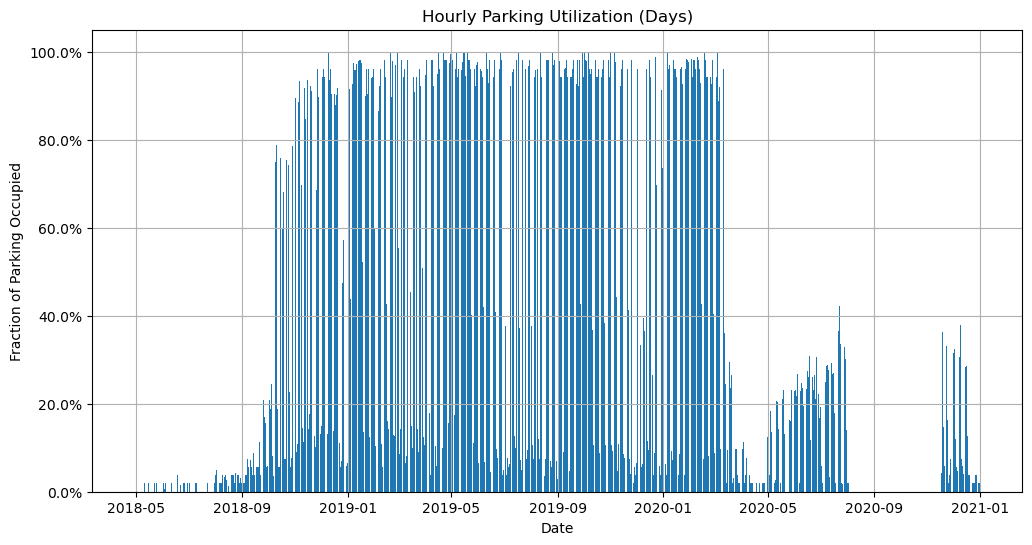

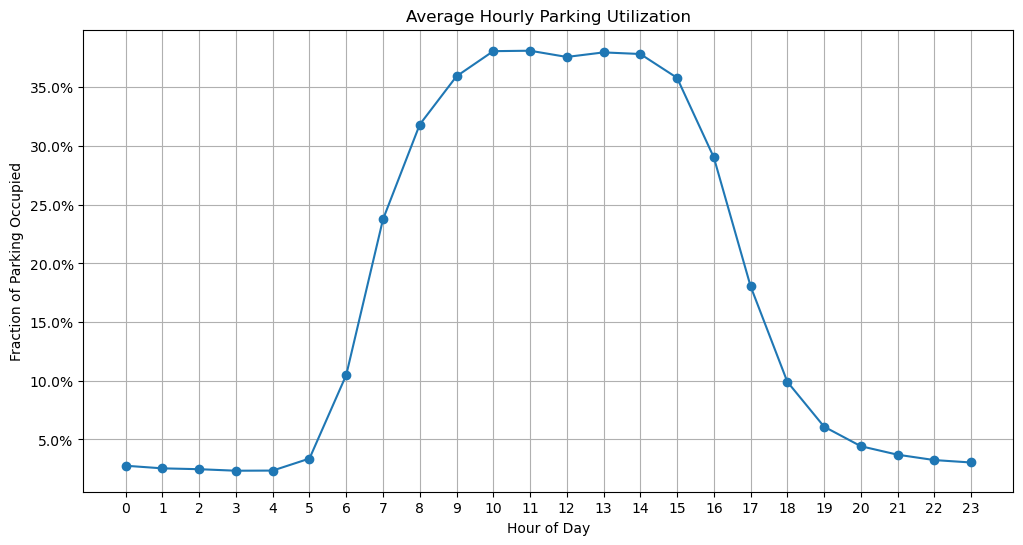

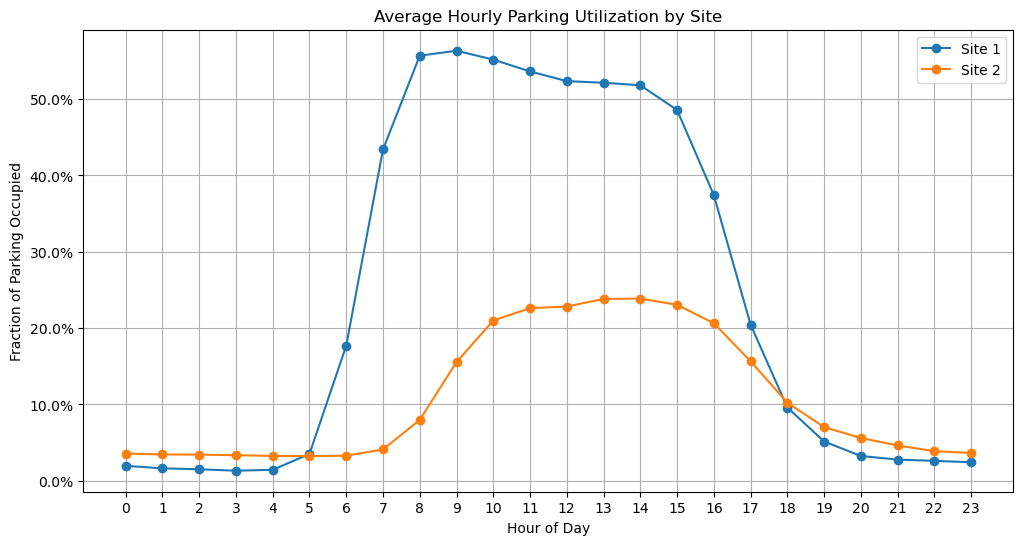

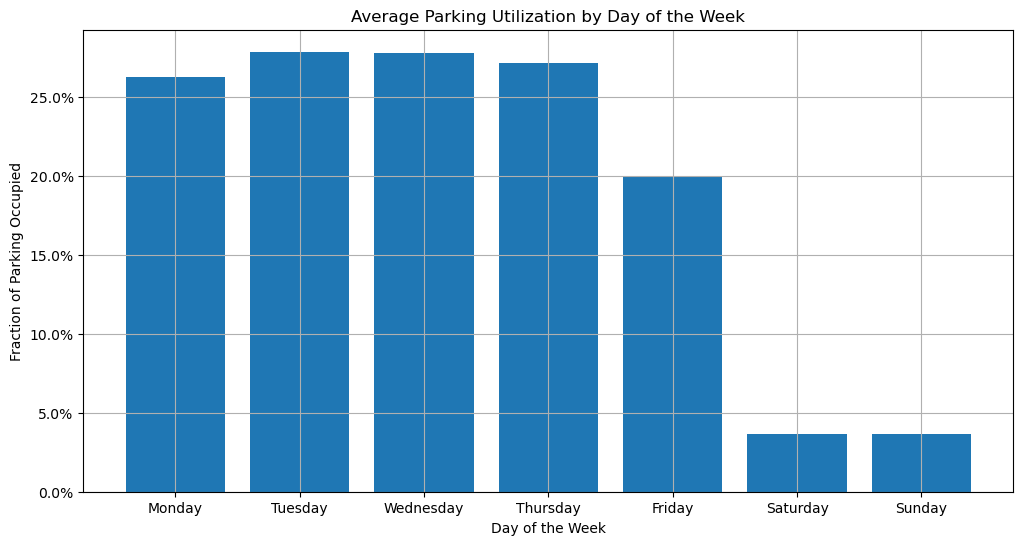

In [2]:
parking_spaces_per_site = df.groupby('siteID')['spaceID'].nunique()

df_occ = df[['siteID', 'spaceID', 'connectionTime', 'disconnectTime']].copy()

df_occ['start_hour'] = df_occ['connectionTime'].dt.floor('h')
df_occ['end_hour'] = df_occ['disconnectTime'].dt.floor('h')

# each row, a list of hourly timestamps the session occupied
def generate_hour_range(row):
    # if end_hour is earlier than start_hour return empty
    if row['end_hour'] < row['start_hour']:
        return []
    return pd.date_range(start=row['start_hour'], end=row['end_hour'], freq='h')


df_occ['hours_active'] = df_occ.apply(generate_hour_range, axis=1)
# each hour on its own row
df_exploded = df_occ.explode('hours_active', ignore_index=True)

# drop empty rows
df_exploded.dropna(subset=['hours_active'], inplace=True)

df_exploded['date'] = df_exploded['hours_active'].dt.date
df_exploded['hour'] = df_exploded['hours_active'].dt.hour

def partial_hour_usage(row):
    hour_start = pd.to_datetime(row['hours_active'])
    hour_end = hour_start + pd.Timedelta(hours=1)
    
    usage_start = max(hour_start, row['connectionTime'])
    usage_end = min(hour_end, row['disconnectTime'])
    
    # compute fractional hours .
    occupied_hours = (usage_end - usage_start).total_seconds() / 3600.0
    
    # If negative, means no overlap
    return max(0.0, occupied_hours)

df_exploded['partial_usage'] = df_exploded.apply(partial_hour_usage, axis=1)

hourly_occ = (
    df_exploded
    .groupby(['siteID', 'date', 'hour'])['partial_usage']
    .sum()
    .reset_index(name='occupied_space_hours')
)


hourly_occ['utilization'] = hourly_occ.apply(
    lambda x: x['occupied_space_hours'] / parking_spaces_per_site[x['siteID']],
    axis=1
)

# group by siteID, hour and compute the mean (averaged utilization across the days)
avg_hourly_utilization = (
    hourly_occ
    .groupby(['siteID', 'hour'], as_index=False)['utilization']
    .mean()
)


# group across all sites by 'hour' and take the mean utilization
overall_avg = avg_hourly_utilization.groupby('hour')['utilization'].mean()


# plot each day’s utilization
plt.figure(figsize=(12, 6))
plt.bar(hourly_occ['date'], hourly_occ['utilization'])
plt.title('Hourly Parking Utilization (Days)')
plt.xlabel('Date')
plt.ylabel('Fraction of Parking Occupied')
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.1%}'.format(y)))
plt.grid(True)
plt.show()



# following plots show at which hour of the day the parking is most utilized

plt.figure(figsize=(12, 6))
plt.plot(overall_avg.index, overall_avg.values, marker='o')
plt.title('Average Hourly Parking Utilization')
plt.xlabel('Hour of Day')
plt.ylabel('Fraction of Parking Occupied')
# format y-axis as percentage
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.1%}'.format(y)))
plt.grid(True)
plt.xticks(range(0, 24))
plt.show()


plt.figure(figsize=(12, 6))

for site in [1, 2]:
    site_data = avg_hourly_utilization[avg_hourly_utilization['siteID'] == site]
    plt.plot(site_data['hour'], site_data['utilization'], 
             label=f'Site {site}', marker='o')

plt.title('Average Hourly Parking Utilization by Site')
plt.xlabel('Hour of Day')
plt.ylabel('Fraction of Parking Occupied')
plt.legend()
plt.grid(True)
plt.xticks(range(0, 24))
# format y-axis as percentage
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.1%}'.format(y)))
plt.show()

# show at whoch day of the week the average utilization is the highest

hourly_occ['day_of_week'] = pd.to_datetime(hourly_occ['date']).dt.day_name()

avg_utilization_by_day = (
    hourly_occ.groupby('day_of_week')['utilization']
    .mean()
    .reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
)

plt.figure(figsize=(12, 6))
plt.bar(avg_utilization_by_day.index, avg_utilization_by_day.values)
plt.title('Average Parking Utilization by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Fraction of Parking Occupied')
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.1%}'.format(y)))
plt.grid(True)
plt.show()

## Parking Turnover Rate

### Definition
Number of new arrivals per hour per space

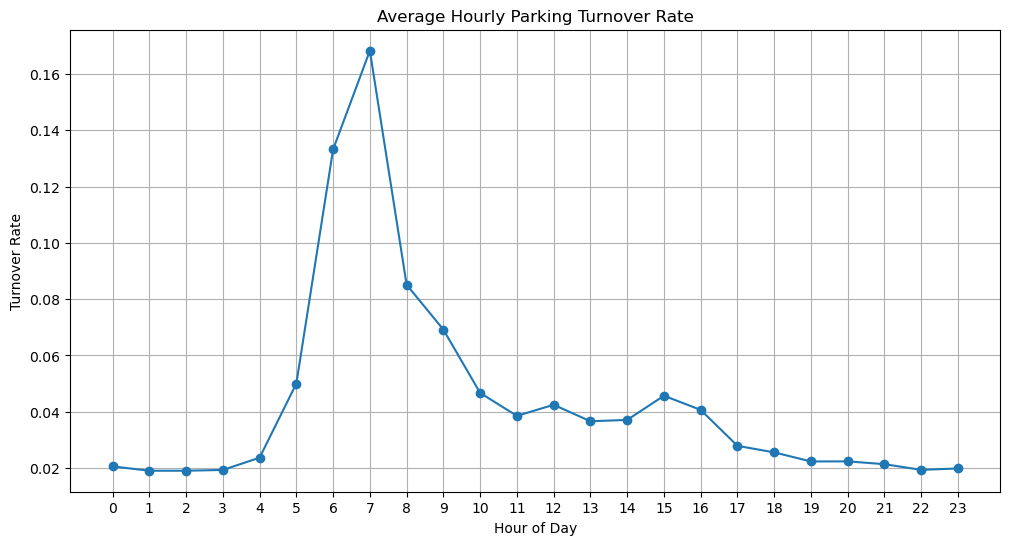

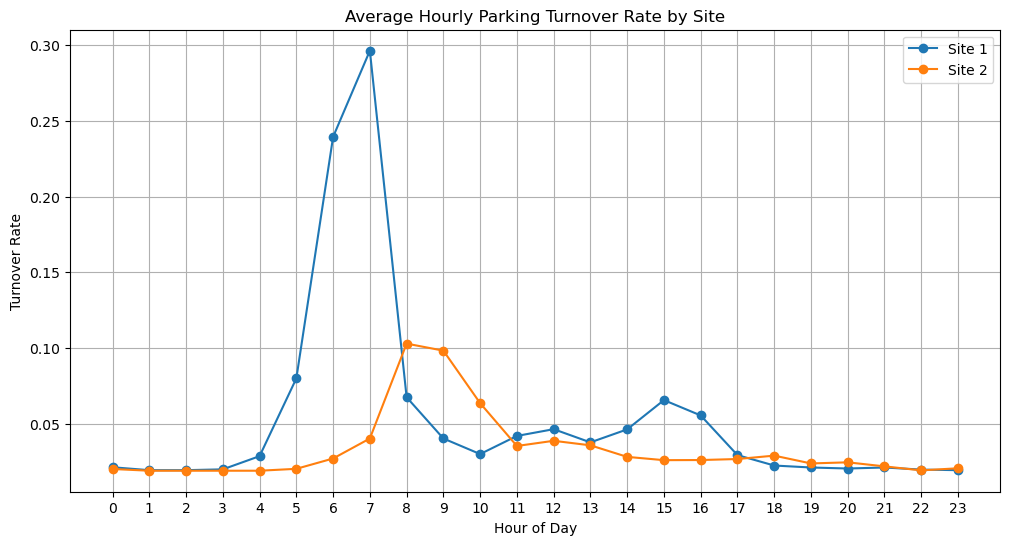

In [3]:
df_turnover = pd.DataFrame({
    'siteID': df['siteID'],
    'spaceID': df['spaceID'],
    'connectionTime': df['connectionTime']
})

df_turnover['date'] = df_turnover['connectionTime'].dt.date
df_turnover['hour'] = df_turnover['connectionTime'].dt.hour

parking_spaces_per_site = df.groupby('siteID')['spaceID'].nunique()


hourly_sessions = (
    df_turnover
    .groupby(['siteID', 'date', 'hour'])['spaceID']
    .count()
    .reset_index(name='num_sessions_started')
)

hourly_sessions['turnover_rate'] = hourly_sessions.apply(
    lambda x: x['num_sessions_started'] / parking_spaces_per_site[x['siteID']],
    axis=1
)

avg_hourly_turnover = (
    hourly_sessions
    .groupby(['siteID', 'hour'], as_index=False)['turnover_rate']
    .mean()
)


plt.figure(figsize=(12, 6))

overall_avg = avg_hourly_turnover.groupby('hour')['turnover_rate'].mean()
plt.plot(overall_avg.index, overall_avg.values, marker='o')

plt.title('Average Hourly Parking Turnover Rate')
plt.xlabel('Hour of Day')
plt.ylabel('Turnover Rate')
plt.grid(True)
plt.xticks(range(0, 24))
plt.show()


plt.figure(figsize=(12, 6))

for site in [1, 2]:
    site_data = avg_hourly_turnover[avg_hourly_turnover['siteID'] == site]
    plt.plot(
        site_data['hour'],
        site_data['turnover_rate'],
        marker='o',
        label=f'Site {site}'
    )

plt.title('Average Hourly Parking Turnover Rate by Site')
plt.xlabel('Hour of Day')
plt.ylabel('Turnover Rate')
plt.legend()
plt.grid(True)
plt.xticks(range(0, 24))
plt.show()

### Definition:
Number of parking spaces that got freed up

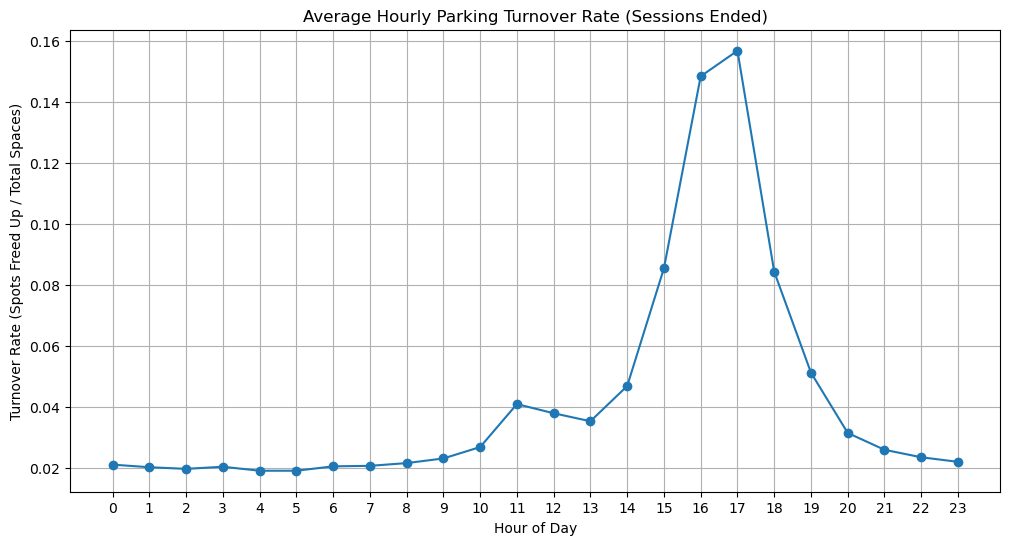

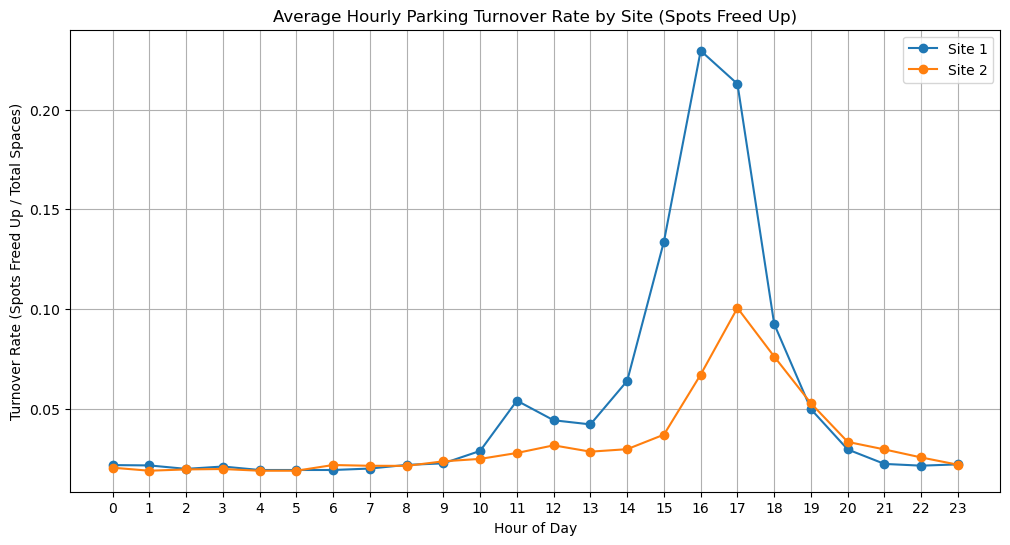

In [4]:
df_turnover_end = pd.DataFrame({
    'siteID': df['siteID'],
    'spaceID': df['spaceID'],
    'disconnectTime': df['disconnectTime']
})

df_turnover_end['date'] = df_turnover_end['disconnectTime'].dt.date
df_turnover_end['hour'] = df_turnover_end['disconnectTime'].dt.hour

parking_spaces_per_site = df.groupby('siteID')['spaceID'].nunique()

hourly_sessions_ended = (
    df_turnover_end
    .groupby(['siteID', 'date', 'hour'])['spaceID']
    .count()
    .reset_index(name='num_sessions_ended')
)

hourly_sessions_ended['turnover_rate'] = hourly_sessions_ended.apply(
    lambda x: x['num_sessions_ended'] / parking_spaces_per_site[x['siteID']],
    axis=1
)

avg_hourly_turnover_end = (
    hourly_sessions_ended
    .groupby(['siteID', 'hour'], as_index=False)['turnover_rate']
    .mean()
)


overall_avg = avg_hourly_turnover_end.groupby('hour', as_index=False)['turnover_rate'].mean()

plt.figure(figsize=(12, 6))
plt.plot(overall_avg['hour'], overall_avg['turnover_rate'], marker='o')
plt.title('Average Hourly Parking Turnover Rate (Sessions Ended)')
plt.xlabel('Hour of Day')
plt.ylabel('Turnover Rate (Spots Freed Up / Total Spaces)')
plt.grid(True)
plt.xticks(range(0, 24))
plt.show()


plt.figure(figsize=(12, 6))
for site in [1, 2]:
    site_data = avg_hourly_turnover_end[avg_hourly_turnover_end['siteID'] == site]
    plt.plot(
        site_data['hour'],
        site_data['turnover_rate'],
        marker='o',
        label=f'Site {site}'
    )
plt.title('Average Hourly Parking Turnover Rate by Site (Spots Freed Up)')
plt.xlabel('Hour of Day')
plt.ylabel('Turnover Rate (Spots Freed Up / Total Spaces)')
plt.legend()
plt.grid(True)
plt.xticks(range(0, 24))
plt.show()


df_duration = df[['siteID', 'connectionTime', 'disconnectTime']].copy()
df_duration['hour'] = df_duration['connectionTime'].dt.hour
df_duration['session_duration_hours'] = (
    df_duration['disconnectTime'] - df_duration['connectionTime']
).dt.total_seconds() / 3600

hourly_avg_duration = (
    df_duration
    .groupby(['siteID', 'hour'], as_index=False)['session_duration_hours']
    .mean()
    .rename(columns={'session_duration_hours': 'avg_session_hours'})
)

## Current Power Demand

### Description: 
This KPI tracks the total electrical power being consumed by all active charging sessions at any given moment.

### Business Value: 
Understanding current power demand is essential for managing energy resources efficiently. It helps in preventing overloading of the electrical infrastructure, optimizing energy use and ensuring the reliability of the charging services.

### Target Value: 
We should always plan to keep a buffer to be able to handle unexpected peaks.

### Actionable Insights:
* Demand is fluctuating
* High CV and persistent 7:00–16:00 peak suggest work-related demand spikes. We should consider offering discounts for off-peak charging to balance the load.

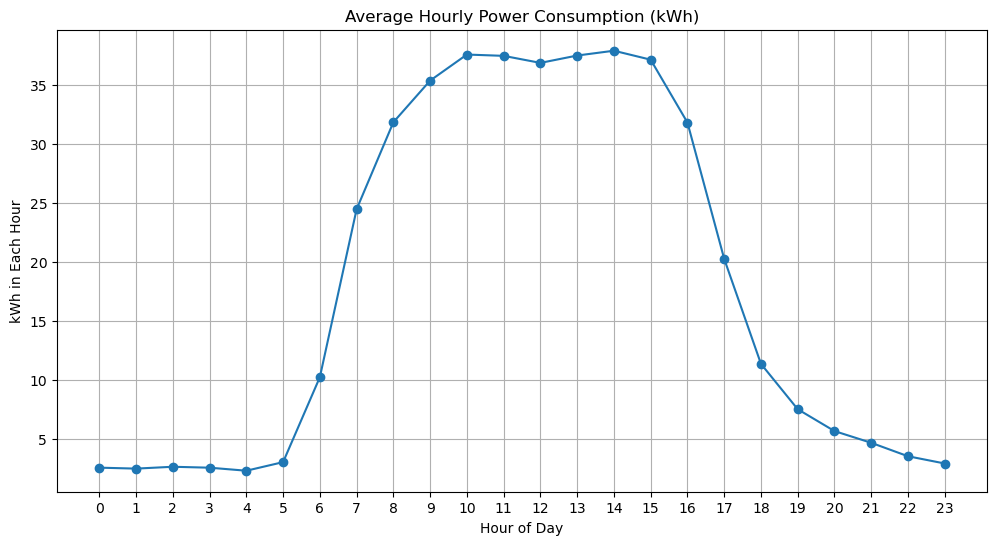

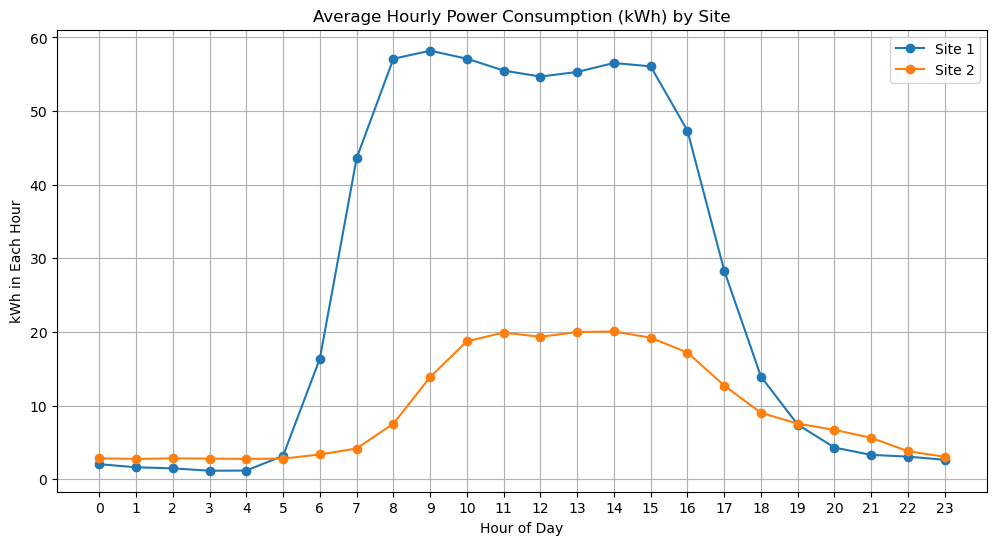

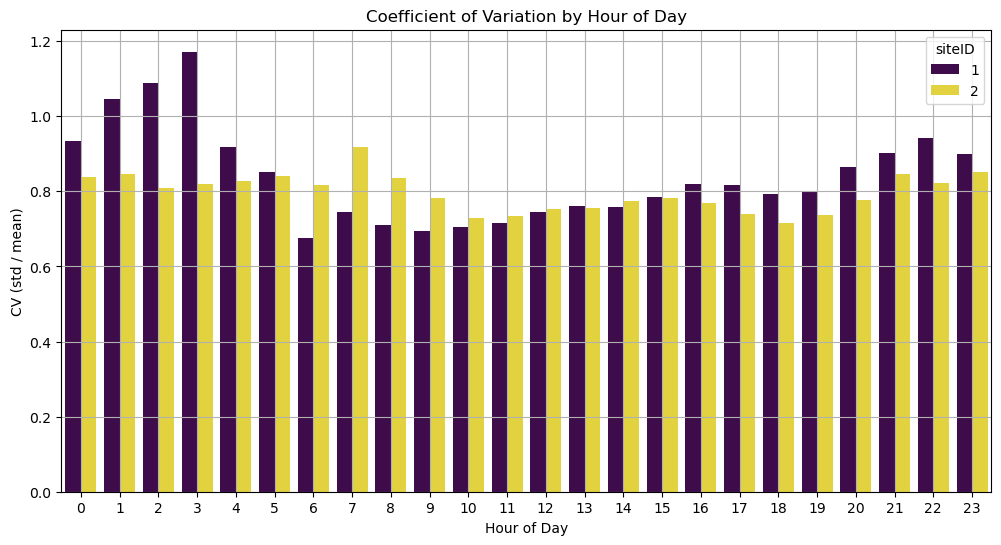

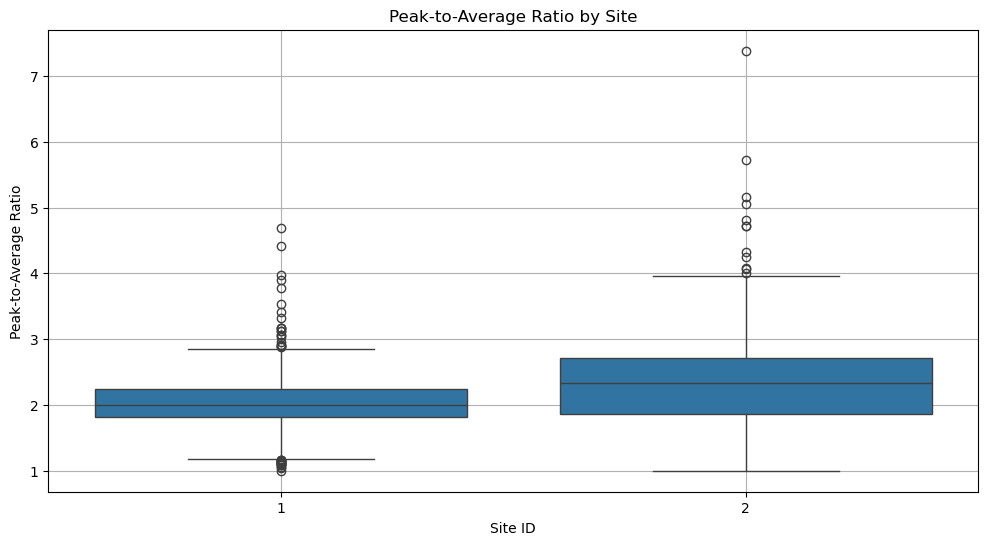

In [5]:
df_kwh = df[['siteID', 'spaceID', 'connectionTime', 'disconnectTime', 'kWhDelivered']].copy()

df_kwh['start_hour'] = df_kwh['connectionTime'].dt.floor('h')
df_kwh['end_hour']   = df_kwh['disconnectTime'].dt.floor('h')

def generate_hour_range(row):
    if row['end_hour'] < row['start_hour']:
        return []
    return pd.date_range(start=row['start_hour'], end=row['end_hour'], freq='h')

df_kwh['hours_active'] = df_kwh.apply(generate_hour_range, axis=1)


df_exploded = df_kwh.explode('hours_active', ignore_index=True)

# drop empty rows
df_exploded.dropna(subset=['hours_active'], inplace=True)

df_exploded['date'] = df_exploded['hours_active'].dt.date
df_exploded['hour'] = df_exploded['hours_active'].dt.hour


# boundaries for each hour block
df_exploded['hour_start'] = df_exploded['hours_active']
df_exploded['hour_end']   = df_exploded['hours_active'] + pd.Timedelta(hours=1)

def partial_hour_usage(row):
    hour_start = row['hour_start']
    hour_end = row['hour_end']
    session_start = row['connectionTime']
    session_end = row['disconnectTime']

    # overlap boundaries
    overlap_start = max(hour_start, session_start)
    overlap_end   = min(hour_end, session_end)

    # overlap in hours (could be zero or negative)
    overlap = (overlap_end - overlap_start).total_seconds() / 3600.0
    return max(0, overlap)

df_exploded['overlap_hours'] = df_exploded.apply(partial_hour_usage, axis=1)

# total session duration in hours
df_exploded['total_session_hours'] = (
    df_exploded['disconnectTime'] - df_exploded['connectionTime']
).dt.total_seconds() / 3600.0

df_exploded['partial_kWh'] = np.where(
    df_exploded['total_session_hours'] > 0,
    df_exploded['kWhDelivered'] * (df_exploded['overlap_hours'] / df_exploded['total_session_hours']),
    0  # if there's no session duration (connectionTime==disconnectTime), set 0
)

hourly_kwh = (
    df_exploded
    .groupby(['siteID', 'date', 'hour'], as_index=False)['partial_kWh']
    .sum()
    .rename(columns={'partial_kWh': 'total_kWh'})
)

avg_hourly_kwh = (
    hourly_kwh
    .groupby(['siteID', 'hour'], as_index=False)['total_kWh']
    .mean()
)

overall_avg_kwh = (
    hourly_kwh
    .groupby('hour', as_index=False)['total_kWh']
    .mean()
)


plt.figure(figsize=(12, 6))
plt.plot(overall_avg_kwh['hour'], overall_avg_kwh['total_kWh'], marker='o')
plt.title('Average Hourly Power Consumption (kWh)')
plt.xlabel('Hour of Day')
plt.ylabel('kWh in Each Hour')
plt.grid(True)
plt.xticks(range(0, 24))
plt.show()


plt.figure(figsize=(12, 6))
for site in [1, 2]:
    site_data = avg_hourly_kwh[avg_hourly_kwh['siteID'] == site]
    plt.plot(
        site_data['hour'], 
        site_data['total_kWh'], 
        label=f'Site {site}', 
        marker='o'
    )
plt.title('Average Hourly Power Consumption (kWh) by Site')
plt.xlabel('Hour of Day')
plt.ylabel('kWh in Each Hour')
plt.legend()
plt.grid(True)
plt.xticks(range(0, 24))
plt.show()


# mean and standard deviation of kWh for each hour (across days)
hourly_variability = (
    hourly_kwh
    .groupby(['siteID', 'hour'])['total_kWh']
    .agg(['mean', 'std'])
    .reset_index()
)

hourly_variability['cv'] = hourly_variability['std'] / hourly_variability['mean']

# check CV for fluctuations
plt.figure(figsize=(12, 6))
sns.barplot(
    data=hourly_variability, 
    x='hour', y='cv', 
    hue='siteID',
    palette='viridis'
)
plt.title('Coefficient of Variation by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('CV (std / mean)')
plt.ylim(0, None)
plt.grid(True)
plt.show()


daily_peaks = (
    hourly_kwh
    .groupby(['siteID', 'date'], as_index=False)['total_kWh']
    .max()
    .rename(columns={'total_kWh': 'daily_peak_kWh'})
)

daily_averages = (
    hourly_kwh
    .groupby(['siteID', 'date'], as_index=False)['total_kWh']
    .mean()
    .rename(columns={'total_kWh': 'daily_avg_kWh'})
)

peak_vs_avg = pd.merge(daily_peaks, daily_averages, on=['siteID', 'date'])
peak_vs_avg['peak_to_avg'] = peak_vs_avg['daily_peak_kWh'] / peak_vs_avg['daily_avg_kWh']

plt.figure(figsize=(12, 6))
sns.boxplot(
    data=peak_vs_avg, 
    x='siteID', 
    y='peak_to_avg'
)
plt.title('Peak-to-Average Ratio by Site')
plt.xlabel('Site ID')
plt.ylabel('Peak-to-Average Ratio')
plt.grid(True)
plt.show()

## Average Session Duration per Hour

### Description: 
This KPI calculates the average length of time that vehicles remain connected to charging stations each hour, highlighting periods when longer sessions are prevalent.

### Business Value: 
By analyzing session durations, we can identify trends in user behavior, such as preferred charging times and potential inefficiencies. This insight supports decisions on pricing strategies, station availability, and customer engagement initiatives.


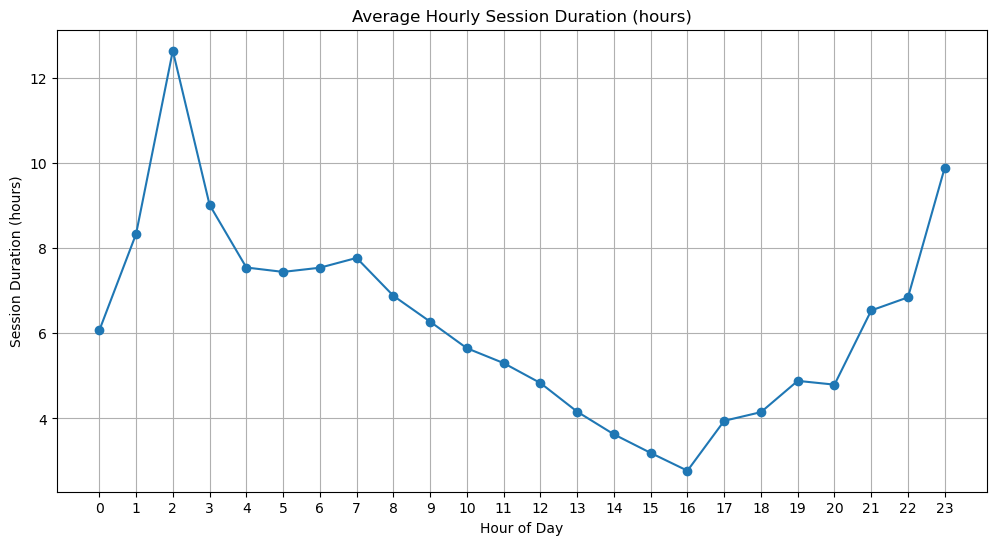

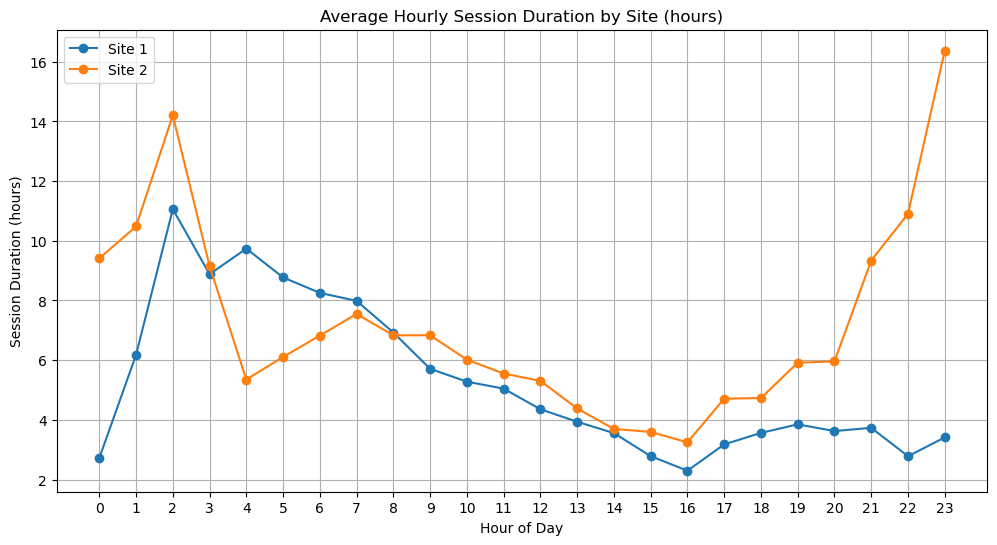

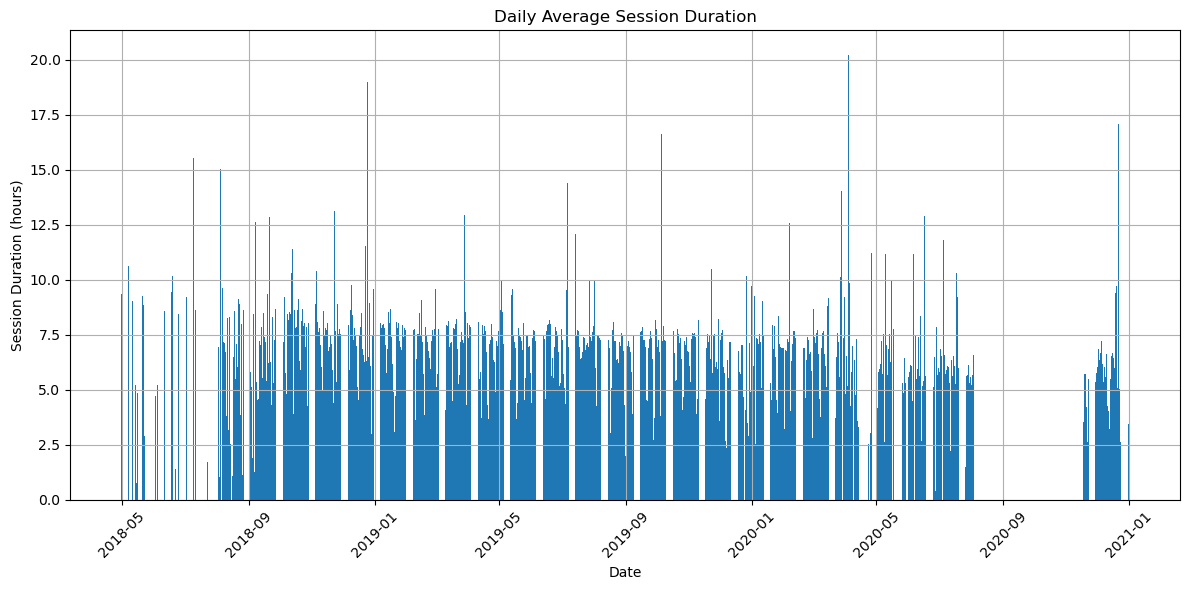

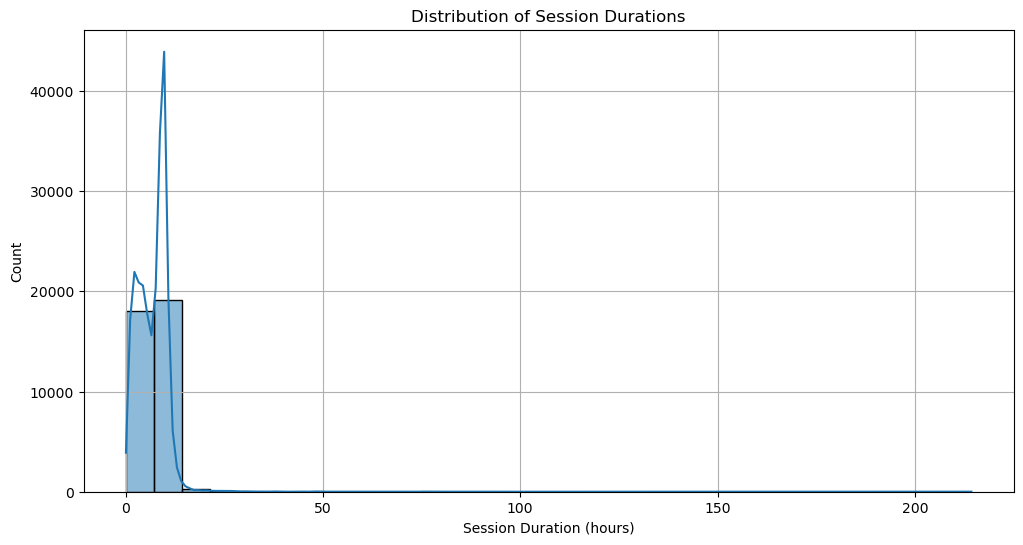

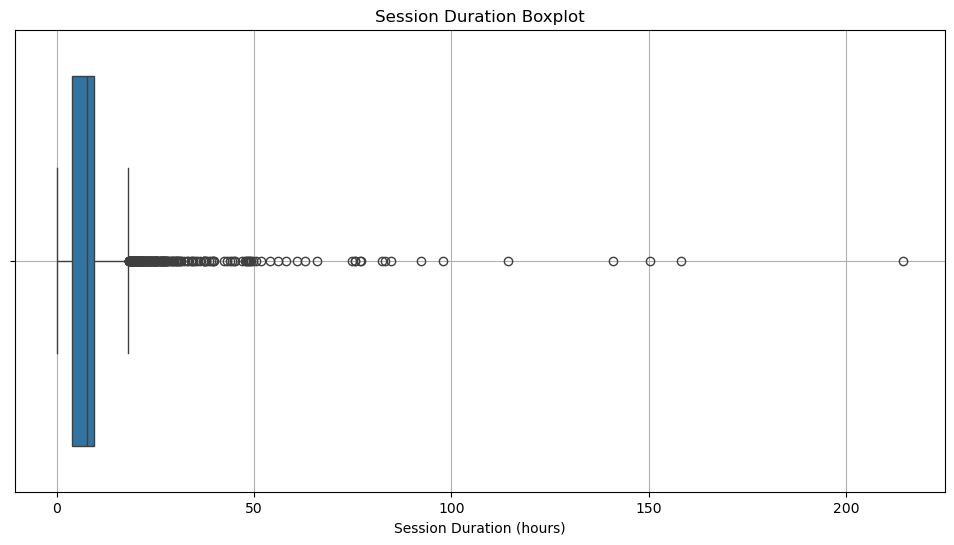

In [6]:
df_sessions = pd.DataFrame({
    'siteID': df['siteID'],
    'connectionTime': df['connectionTime'],
    'disconnectTime': df['disconnectTime']
})

df_sessions['date'] = df_sessions['connectionTime'].dt.date
df_sessions['hour'] = df_sessions['connectionTime'].dt.hour

df_sessions['sessionDuration'] = (
    df_sessions['disconnectTime'] - df_sessions['connectionTime']
).dt.total_seconds() / 3600


# group by site, date, hour and compute mean session duration
hourly_duration = df_sessions.groupby(['siteID', 'date', 'hour'])['sessionDuration'].mean().reset_index()

# calculate average session duration per hour across days for each site
avg_hourly_duration = hourly_duration.groupby(['siteID', 'hour'])['sessionDuration'].mean().reset_index()

daily_duration = (
    df_sessions
    .groupby(['siteID', 'date'], as_index=False)['sessionDuration']
    .mean()
    .rename(columns={'sessionDuration': 'avg_session_hours'})
)

plt.figure(figsize=(12, 6))
overall_avg = avg_hourly_duration.groupby('hour')['sessionDuration'].mean()
plt.plot(overall_avg.index, overall_avg.values, marker='o')
plt.title('Average Hourly Session Duration (hours)')
plt.xlabel('Hour of Day')
plt.ylabel('Session Duration (hours)')
plt.grid(True)
plt.xticks(range(0, 24))
plt.show()


plt.figure(figsize=(12, 6))
for site in [1, 2]:
    site_data = avg_hourly_duration[avg_hourly_duration['siteID'] == site]
    plt.plot(site_data['hour'], site_data['sessionDuration'],
             label=f'Site {site}', marker='o')

plt.title('Average Hourly Session Duration by Site (hours)')
plt.xlabel('Hour of Day')
plt.ylabel('Session Duration (hours)')
plt.grid(True)
plt.legend()
plt.xticks(range(0, 24))
plt.show()


plt.figure(figsize=(12, 6))
plt.bar(daily_duration['date'], daily_duration['avg_session_hours'])
plt.title('Daily Average Session Duration')
plt.xlabel('Date')
plt.ylabel('Session Duration (hours)')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# helps see if sessions tend to cluster at short durations or long durations
plt.figure(figsize=(12, 6))
sns.histplot(data=df_sessions, x='sessionDuration', bins=30, kde=True)
plt.title('Distribution of Session Durations')
plt.xlabel('Session Duration (hours)')
plt.ylabel('Count')
plt.grid(True)
plt.show()

# to see how widely durations vary
plt.figure(figsize=(12, 6))
sns.boxplot(x=df_sessions['sessionDuration'])
plt.title('Session Duration Boxplot')
plt.xlabel('Session Duration (hours)')
plt.grid(True)
plt.show()


## Idle Time

### Description: 
This KPI measures the duration for which vehicles occupy charging stations beyond their actual charging needs, indicating how long a station remains occupied without active charging.

### Business Value: 
High idle times can lead to reduced station availability and customer dissatisfaction. Monitoring this metric helps us to implement strategies such as idle fees or user notifications to encourage timely vehicle removal, thereby improving station turnover and revenue potential.

### Target Value: 
Minimizing idle time is crucial. We should aim for low idle time fraction of the total session time. Especially during peak hours, stations should be available for active charging to maximize revenue and customer satisfaction.

### Actionable Insights
The boxplot reveals significant variability or outliers and generally a high average idle time fraction of the total session, we should:
* Sessions with the highest idle times mostly occur during the night, suggesting overnight parking. Blocked Stations during off-peak hours should not be a problem. But we could implement policies to limit excessive idle time, during peak hours, such as introducing penalties for users who overstay. The average idle time is quite high
* Additionally, we could explore ways to incentivize users to move their vehicles once charging is complete, such as offering discounts for prompt departure.

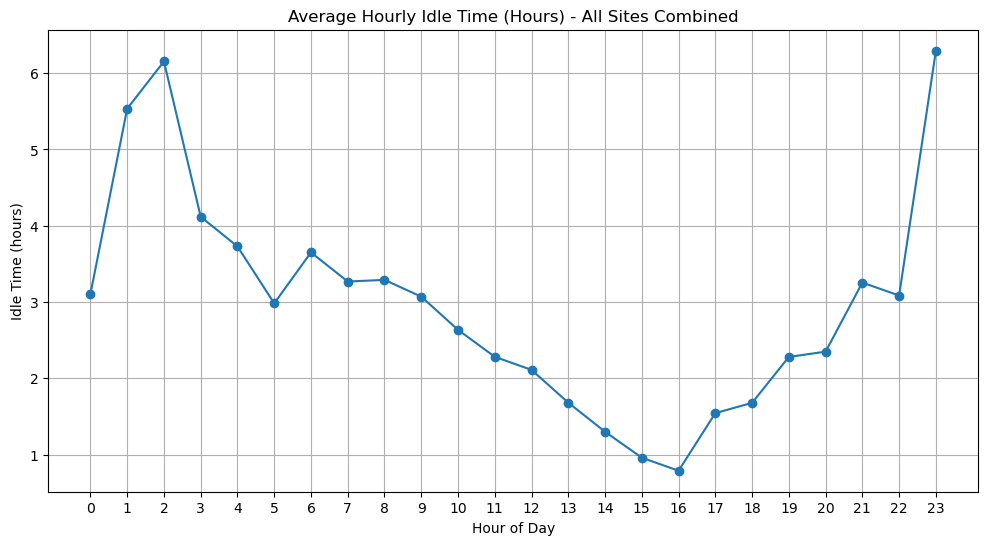

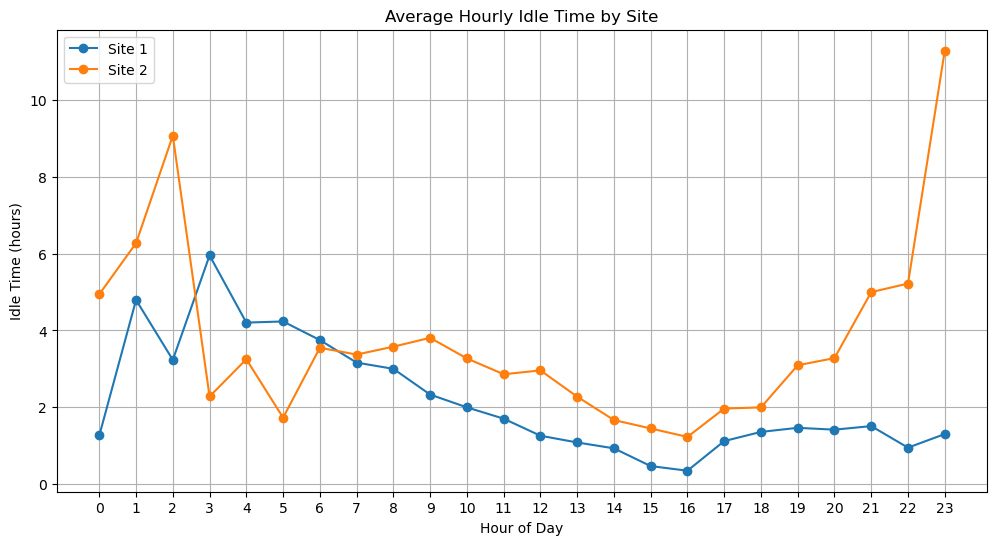

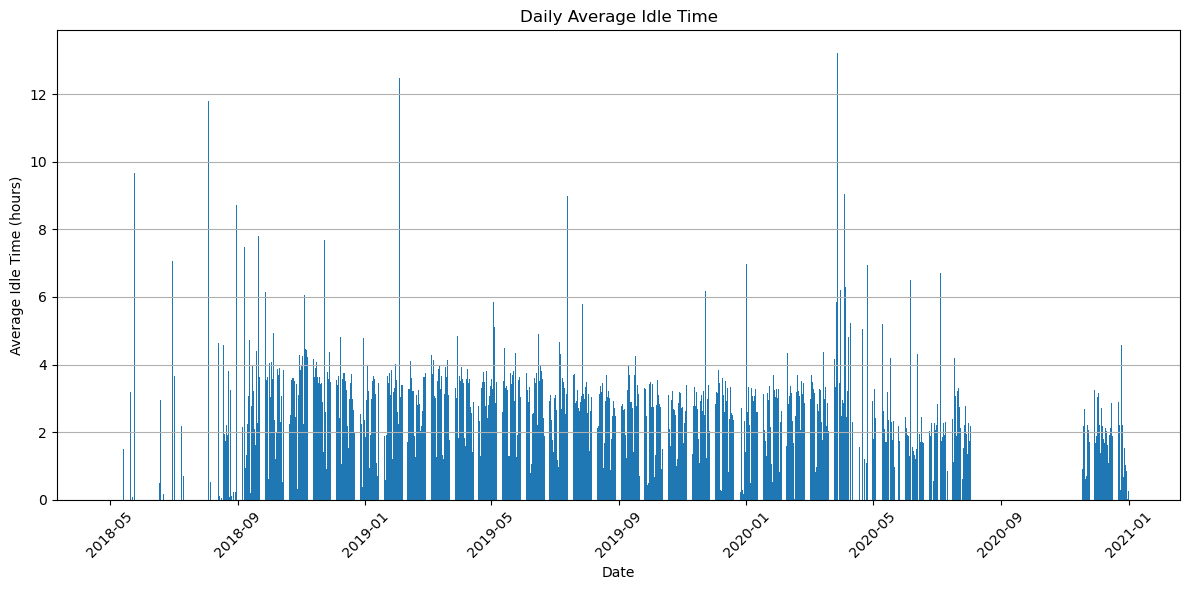

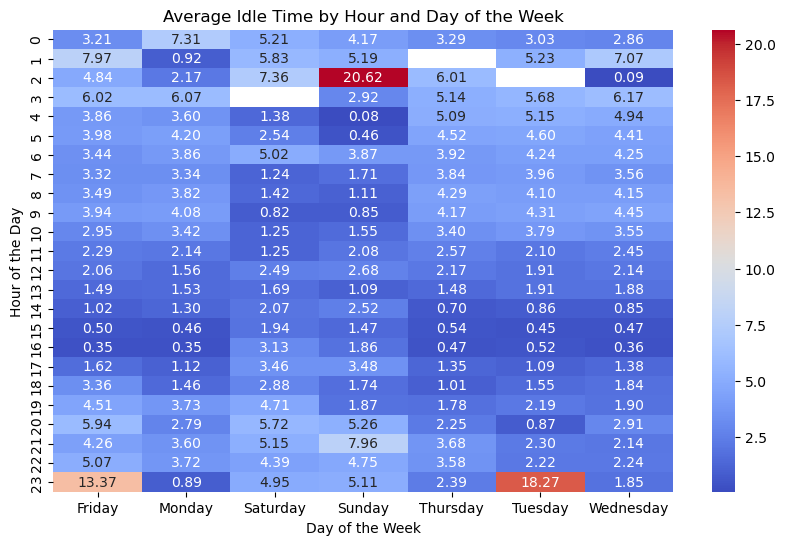

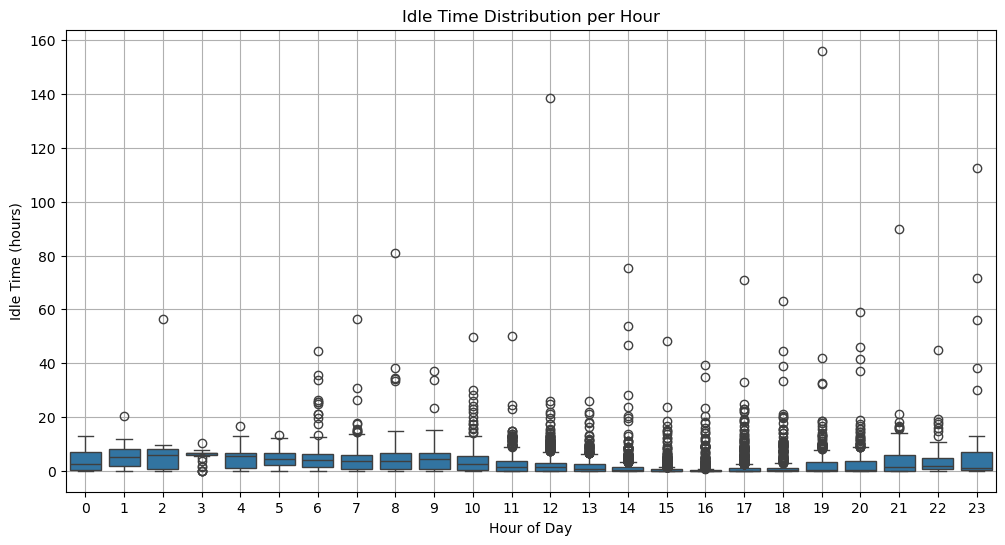

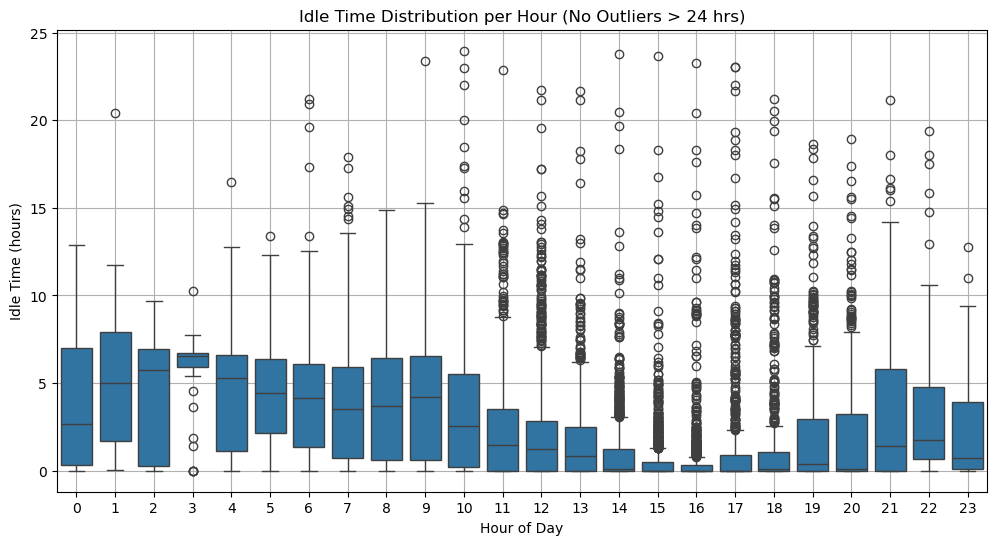

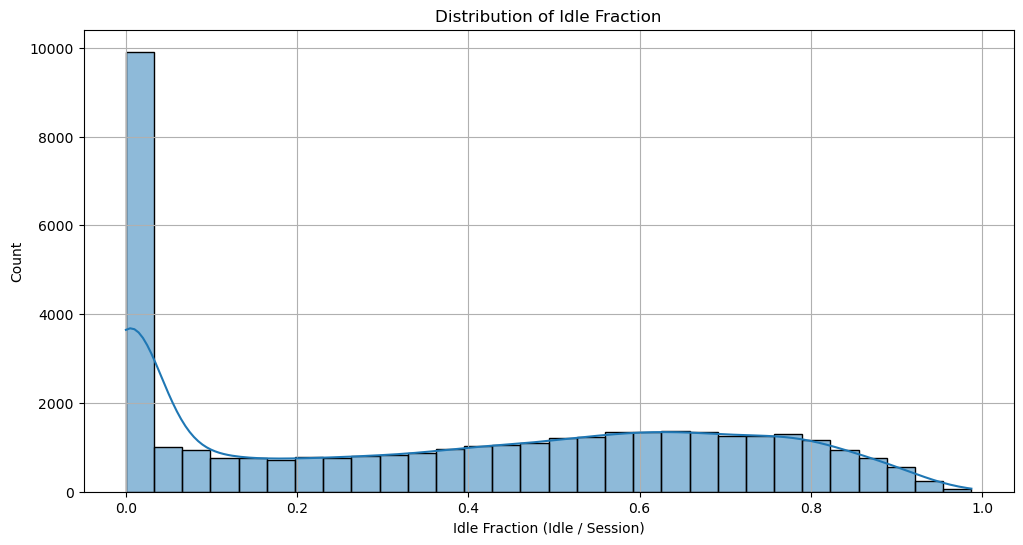

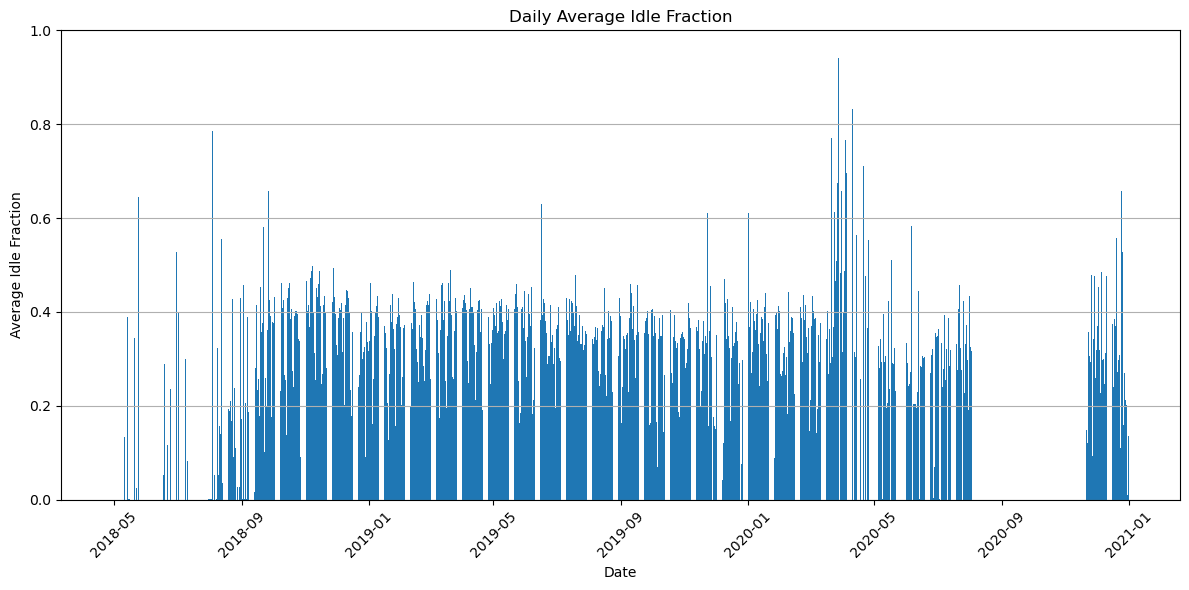

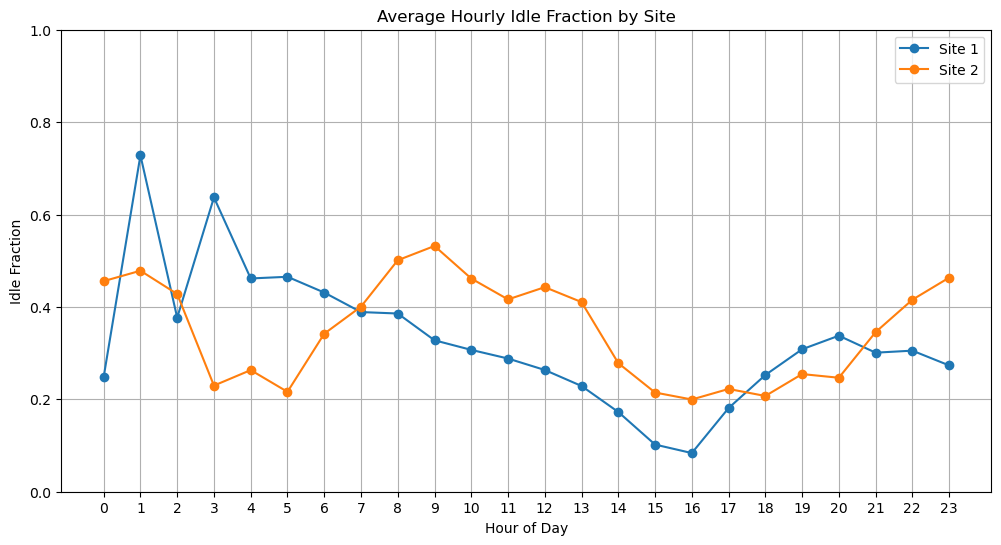

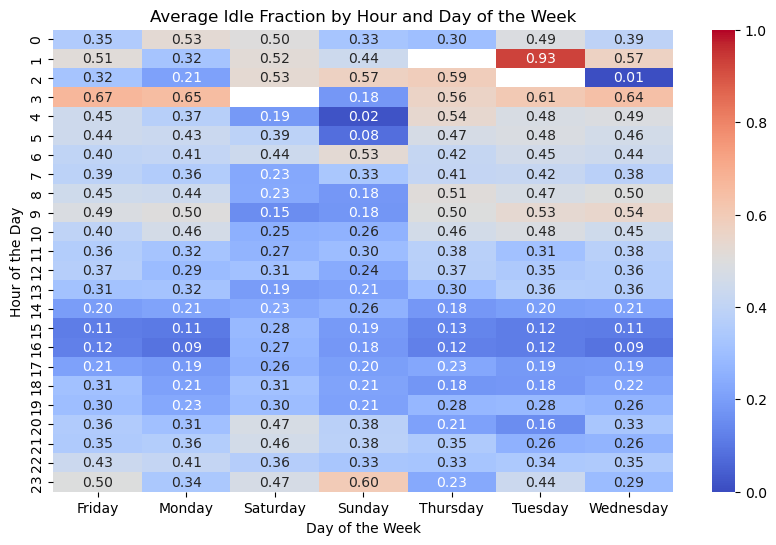

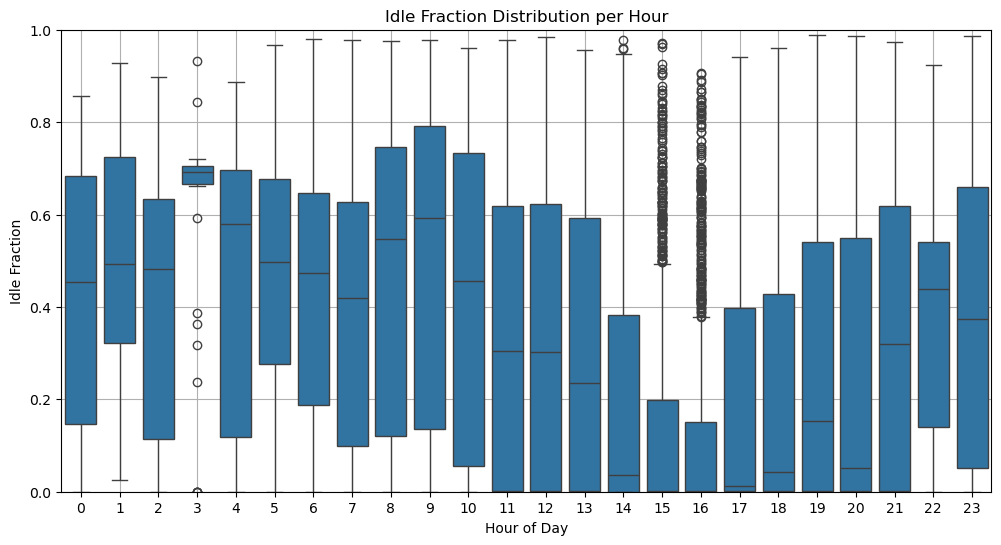

In [7]:
df_idle = pd.DataFrame({
    'siteID': df['siteID'],
    'connectionTime': df['connectionTime'],
    'doneChargingTime': pd.to_datetime(df['doneChargingTime'], errors='coerce'),
    'disconnectTime': df['disconnectTime']
})

df_idle['idle_time_hours'] = (
    df_idle.apply(
        lambda row: max(
            0,
            (row['disconnectTime'] - row['doneChargingTime']).total_seconds() / 3600
        )
        if pd.notnull(row['doneChargingTime']) else 0,
        axis=1
    )
)

df_idle['session_time_hours'] = (
    df_idle['disconnectTime'] - df_idle['connectionTime']
).dt.total_seconds() / 3600

df_idle['idle_fraction'] = np.where(
    df_idle['session_time_hours'] > 0,
    df_idle['idle_time_hours'] / df_idle['session_time_hours'],
    0
)

df_idle['date'] = df_idle['connectionTime'].dt.date
df_idle['hour'] = df_idle['connectionTime'].dt.hour

idle_kpi = (
    df_idle
    .groupby(['siteID', 'date', 'hour'], as_index=False)
    .agg({
        'idle_time_hours': 'mean',
        'idle_fraction': 'mean'
    })
    .rename(columns={
        'idle_time_hours': 'avg_idle_hours',
        'idle_fraction': 'avg_idle_fraction'
    })
)

df_idle['date'] = df_idle['connectionTime'].dt.date

# average idle time (in hours) by date
daily_idle = (
    df_idle
    .groupby('date', as_index=False)['idle_time_hours']
    .mean()
    .rename(columns={'idle_time_hours': 'avg_idle_time_hours'})
)

# average across dates, for each site and hour
avg_idle_per_hour = (
    idle_kpi
    .groupby(['siteID', 'hour'], as_index=False)
    .agg({
        'avg_idle_hours': 'mean',
        'avg_idle_fraction': 'mean'
    })
)

plt.figure(figsize=(12, 6))
overall_idle = (
    avg_idle_per_hour
    .groupby('hour')['avg_idle_hours']
    .mean()
)
plt.plot(overall_idle.index, overall_idle.values, marker='o')
plt.title('Average Hourly Idle Time (Hours) - All Sites Combined')
plt.xlabel('Hour of Day')
plt.ylabel('Idle Time (hours)')
plt.xticks(range(0, 24))
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 6))
for site in [1, 2]:
    site_data = avg_idle_per_hour[avg_idle_per_hour['siteID'] == site]
    plt.plot(
        site_data['hour'], site_data['avg_idle_hours'], 
        marker='o', label=f'Site {site}'
    )
plt.title('Average Hourly Idle Time by Site')
plt.xlabel('Hour of Day')
plt.ylabel('Idle Time (hours)')
plt.xticks(range(0, 24))
plt.legend()
plt.grid(True)
plt.show()


plt.figure(figsize=(12, 6))
plt.bar(daily_idle['date'], daily_idle['avg_idle_time_hours'])
plt.title('Daily Average Idle Time')
plt.xlabel('Date')
plt.ylabel('Average Idle Time (hours)')
plt.xticks(rotation=45)
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

# Heatmap
df_idle['day_of_week'] = pd.to_datetime(df_idle['date']).dt.day_name()
heatmap_data = df_idle.pivot_table(index='hour', columns='day_of_week', values='idle_time_hours', aggfunc='mean')

plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, cmap='coolwarm', annot=True, fmt='.2f')
plt.title('Average Idle Time by Hour and Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Hour of the Day')
plt.show()

plt.figure(figsize=(12, 6))
sns.boxplot(x='hour', y='idle_time_hours', data=df_idle)
plt.title('Idle Time Distribution per Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Idle Time (hours)')
plt.grid(True)
plt.show()

# no Outliers > 24 hrs
df_filtered_idle = df_idle[df_idle['idle_time_hours'] <= 24]
plt.figure(figsize=(12, 6))
sns.boxplot(x='hour', y='idle_time_hours', data=df_filtered_idle)
plt.title('Idle Time Distribution per Hour (No Outliers > 24 hrs)')
plt.xlabel('Hour of Day')
plt.ylabel('Idle Time (hours)')
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 6))
sns.histplot(data=df_idle, x='idle_fraction', bins=30, kde=True)
plt.title('Distribution of Idle Fraction')
plt.xlabel('Idle Fraction (Idle / Session)')
plt.ylabel('Count')
plt.grid(True)
plt.show()

daily_idle_fraction = (
    df_idle
    .groupby('date', as_index=False)['idle_fraction']
    .mean()
    .rename(columns={'idle_fraction': 'avg_idle_fraction'})
)

plt.figure(figsize=(12, 6))
plt.bar(daily_idle_fraction['date'], daily_idle_fraction['avg_idle_fraction'])
plt.title('Daily Average Idle Fraction')
plt.xlabel('Date')
plt.ylabel('Average Idle Fraction')
plt.xticks(rotation=45)
plt.ylim(0, 1)
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

avg_idle_fraction_per_hour = (
    df_idle
    .groupby(['siteID', 'hour'], as_index=False)['idle_fraction']
    .mean()
    .rename(columns={'idle_fraction': 'avg_idle_fraction'})
)

plt.figure(figsize=(12, 6))
for site in [1, 2]:
    site_data = avg_idle_fraction_per_hour[avg_idle_fraction_per_hour['siteID'] == site]
    plt.plot(
        site_data['hour'], site_data['avg_idle_fraction'], 
        marker='o', label=f'Site {site}'
    )
plt.title('Average Hourly Idle Fraction by Site')
plt.xlabel('Hour of Day')
plt.ylabel('Idle Fraction')
plt.xticks(range(0, 24))
plt.ylim(0, 1)
plt.legend()
plt.grid(True)
plt.show()

# Heatmap
heatmap_data_fraction = df_idle.pivot_table(
    index='hour', 
    columns='day_of_week', 
    values='idle_fraction', 
    aggfunc='mean'
)

plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data_fraction, cmap='coolwarm', annot=True, fmt='.2f', vmin=0, vmax=1)
plt.title('Average Idle Fraction by Hour and Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Hour of the Day')
plt.show()


plt.figure(figsize=(12, 6))
sns.boxplot(x='hour', y='idle_fraction', data=df_idle)
plt.title('Idle Fraction Distribution per Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Idle Fraction')
plt.ylim(0, 1)
plt.grid(True)
plt.show()

---